In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import keras
import matplotlib.pyplot as plt

In [3]:
#-------------------------------------------------------------------------------------------------------------

# Neural Networks

#-------------------------------------------------------------------------------------------------------------

Input shape: 2470
Output shape: (63,)
Epoch 1/150
 997/1000 [============================>.] - ETA: 0s - loss: 2.5892 - categorical_accuracy: 0.2831
Epoch 1: val_categorical_accuracy improved from -inf to 0.34419, saving model to best_checkpoint
1000/1000 [==============================] - 21s 19ms/step - loss: 2.5884 - categorical_accuracy: 0.2833 - val_loss: 2.1852 - val_categorical_accuracy: 0.3442
Epoch 2/150
1000/1000 [==============================] - ETA: 0s - loss: 2.2068 - categorical_accuracy: 0.3485
Epoch 2: val_categorical_accuracy improved from 0.34419 to 0.36419, saving model to best_checkpoint
1000/1000 [==============================] - 19s 19ms/step - loss: 2.2068 - categorical_accuracy: 0.3485 - val_loss: 2.1300 - val_categorical_accuracy: 0.3642
Epoch 3/150
 999/1000 [============================>.] - ETA: 0s - loss: 2.1089 - categorical_accuracy: 0.3669
Epoch 3: val_categorical_accuracy improved from 0.36419 to 0.38169, saving model to best_checkpoint
1000/1000 [===

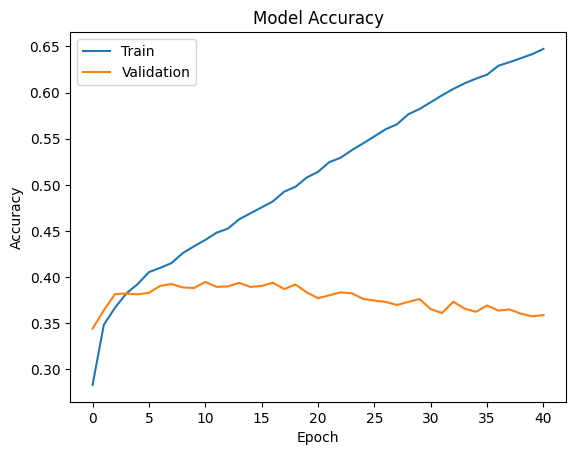

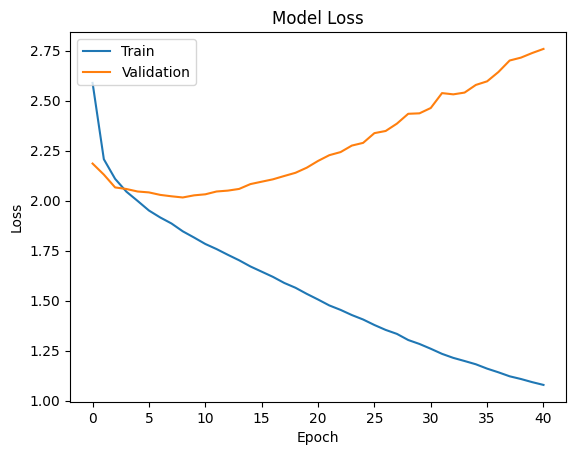

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import keras
import matplotlib.pyplot as plt

f1 = pd.read_csv("/content/drive/MyDrive/clean_data2.csv", low_memory=False,nrows=100000 )

f1 = f1[['Registration State','Plate Type','Issue Date','Violation Code','Vehicle Body Type','Vehicle Make','Issuing Agency','Violation Precinct',
'Issuer Precinct','Violation Hour','Violation County','Street Name','Vehicle Color']]

f = f1.dropna()
train_thres = int((80/100)*len(f))

data = {}
label_enc = {}
for (columnName, columnData) in f.iteritems():
    if columnName == "Violation Code":
        label_enc["Violation Code"] = OneHotEncoder(sparse=False)
        col_data = columnData.values.reshape(-1,1)
        enc_col_data = label_enc["Violation Code"].fit_transform(col_data)
    else:
        enc = OneHotEncoder(sparse=False)
        col_data = columnData.values.reshape(-1,1)
        enc_col_data = enc.fit_transform(col_data)
    data[columnName] = enc_col_data

zipped_data = [np.concatenate(list(a)).ravel() for a in zip(data['Registration State'],data['Plate Type'],data['Issue Date'],data['Vehicle Body Type'],data['Vehicle Make'],data['Issuing Agency'],data['Violation Precinct'],
data['Issuer Precinct'],data['Violation Hour'],data['Violation County'], data['Vehicle Color'], data['Street Name'])]

labels = [np.concatenate(list(a)).ravel() for a in zip(data['Violation Code'])]

train_data = np.array(zipped_data[:train_thres])
test_data = np.array(zipped_data[train_thres:])
train_labels = np.array(labels[:train_thres])
test_labels = np.array(labels[train_thres:])

print("Input shape: {}".format(len(train_data[0])))
print("Output shape: {}".format(train_labels[0].shape))
# Model architecture with added dropout and batch normalization
model = Sequential()
model.add(Dense(units=256, input_dim=len(train_data[0])))
model.add(LeakyReLU())
model.add(Dense(units=256, kernel_initializer=keras.initializers.he_uniform(seed=None)))
model.add(LeakyReLU())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(Dense(units=128, kernel_initializer=keras.initializers.he_uniform(seed=None)))
model.add(LeakyReLU())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(Dense(units=128, kernel_initializer=keras.initializers.he_uniform(seed=None)))
model.add(LeakyReLU())
model.add(Dense(units=len(train_labels[0]), activation='softmax', kernel_initializer=keras.initializers.he_uniform(seed=None)))
# Compile the model with a different optimizer and learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

log_file = "best_checkpoint"
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=30)
checkpoint = ModelCheckpoint(log_file, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# Train the model with increased number of epochs
history = model.fit(train_data, train_labels, batch_size=64, validation_split=0.2, epochs=150, callbacks=[checkpoint, early_stopping])


# Evaluate the model
res = model.evaluate(test_data, test_labels)
print("Test accuracy is {}".format(res[1]))


with open('./train_history', 'wb') as file:
    pickle.dump(history.history, file)

# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("accuracy.png")

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("loss.png")

model = load_model("best_checkpoint")
res = model.evaluate(test_data, test_labels)
print("Neural Networks Test categorical accuracy is {}".format(res[1]))

preds = model.predict(test_data)
preds = label_enc["Violation Code"].inverse_transform(preds)

print("Predictions:", preds)

In [ ]:
#-------------------------------------------------------------------------------------------------------------

# Random Forest

#-------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

# Load the dataset
f1 = pd.read_csv("/content/drive/MyDrive/clean_data2.csv", low_memory=False, nrows=200000)

# Select relevant columns
f1 = f1[['Registration State','Plate Type','Issue Date','Violation Code','Vehicle Body Type','Vehicle Make','Issuing Agency','Violation Precinct',
'Issuer Precinct','Violation Hour','Violation County','Street Name','Vehicle Color']]

# Remove rows with missing values
f = f1.dropna()

# Encode categorical columns
label_enc = LabelEncoder()
for column in f.columns:
    if f[column].dtype == type(object):
        f[column] = label_enc.fit_transform(f[column])

# Define input and output data
X = f.drop('Violation Code', axis=1)
y = f['Violation Code']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(model, X, y, cv=kfold)

# Print the cross-validation results
print("Random Forest Test accuracy is {}".format(accuracy))

Test accuracy is 0.34985


In [12]:
#-------------------------------------------------------------------------------------------------------------

# Decision Tree

#-------------------------------------------------------------------------------------------------------------

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

# Load the dataset
f1 = pd.read_csv("/content/drive/MyDrive/clean_data2.csv", low_memory=False,nrows=200000)

# Select relevant columns
f1 = f1[['Registration State','Plate Type','Issue Date','Violation Code','Vehicle Body Type','Vehicle Make','Issuing Agency','Violation Precinct',
'Issuer Precinct','Violation Hour','Violation County','Street Name','Vehicle Color']]

# Remove rows with missing values
f = f1.dropna()

# Encode categorical columns
label_enc = LabelEncoder()
for column in f.columns:
    if f[column].dtype == type(object):
        f[column] = label_enc.fit_transform(f[column])

# Define input and output data
X = f.drop('Violation Code', axis=1)
y = f['Violation Code']

# Build the Decision Tree model
model = DecisionTreeClassifier()

# Perform 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(model, X, y, cv=kfold)

# Print the cross-validation results
print("Decision Tree Test accuracy is {}".format(results))


Test accuracy is 35.0


In [13]:
#-------------------------------------------------------------------------------------------------------------

# KNN

#-------------------------------------------------------------------------------------------------------------

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Load the dataset
f1 = pd.read_csv("/content/drive/MyDrive/clean_data2.csv", low_memory=False, nrows=200000)

# Select relevant columns
f1 = f1[['Registration State','Plate Type','Issue Date','Violation Code','Vehicle Body Type','Vehicle Make','Issuing Agency','Violation Precinct',
'Issuer Precinct','Violation Hour','Violation County','Street Name','Vehicle Color']]

# Remove rows with missing values
f = f1.dropna()

# Encode categorical columns
label_enc = LabelEncoder()
for column in f.columns:
    if f[column].dtype == type(object):
        f[column] = label_enc.fit_transform(f[column])

# Define input and output data
X = f.drop('Violation Code', axis=1)
y = f['Violation Code']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Build the KNN model
model = KNeighborsClassifier(n_neighbors=50)  # You can adjust the number of neighbors (k) as needed

# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(model, X, y, cv=kfold)

# Print the cross-validation results
print("KNN Test accuracy is {}".format(results))

Decision Tree Test accuracy is [0.2515 0.2565 0.251  0.2525 0.251 ]
